# 🧠🤖 Treinamento de Redes LSTM para Classificação

- **Deadline**: 24/08/2025
- **Entrega**: O trabalho deve ser entregue via sistema Testr.
- **Pontuação**: 50% da nota do T2 (+1 ponto extra).
- O trabalho deve ser realizado individualmente.



## Especificação


### Contexto

O trabalho consiste em realizar o treinamento de redes LSTM usando a base de dados [BBC News Archive disponível no kaggle](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv). Esta base de dados contém 2.225 textos publicados no site de notícias da BBC news entre 2004-2005. Cada notícia foi classificada como sendo de um dos seguintes assuntos: business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).

O objetivo do trabalho é treinar uma rede neural capaz de identificar o tema de um texto.


### Implementação

- Use o notebook de classificação de sentimentos como ponto de partida.
- use a biblioteca `kagglehub` para fazer o download do dataset no colab.
- Um dos modelos de *word embeddings* disponíveis na biblioteca `gensim` deve ser utilizado para mapear palavras em vetores.
- Use o tipo `nn.LSTM` disponível no `pytorch` (não é necessário implementar a camada LSTM do zero).
- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final.
- Você pode optar por cortar os textos em um tamanho máximo (e.g., 100 palavras), como fizemos no notebook, para que os testes não demorem muito.
- Use o ambiente de `GPU` do colab para evitar que o treinamento demore excessivamente.
- Durante o desenvolvimento, é uma boa idéia usar um subconjunto (e.g., 10%) das notícias para que os testes sejam mais rápidos. Quando tudo estiver correto, faça o treinamento com a base completa.
- Deve ser plotado o gráfico mostrando a evolução da função de perda nos conjuntos de treino e validação.
- Devem ser mostradas as métricas geradas pela função `classification_report` da biblioteca scikit-learn e a matriz de confusão para o conjunto de teste.
- Faça alguns testes qualitativos com textos escritos com você (não use textos da base de dados).
- Discuta brevemente os resultados quantitativos e qualitativos (1-2 parágrafos, no máximo).



### Pontos Extras

Receberá um ponto extra, o aluno que:
- Utilizar um LLM baseado em Transformer pré-treinado (e.g., [BERT](https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6)) para mapear as notícias em *embeddings*.
- Utilizar uma rede Multilayer Perceptron para classificar os *embeddings*.
- Comparar a performance desta solução com a LSTM.

⚠️**IMPORTANTE**⚠️
- Não é necessário (nem recomendável considerando o prazo) tentar realizar *fine-tuning* do LLM pré-treinado.
- Estes modelos são SUPER-ULTRA-MASTER-BLASTER lentos na CPU. Use o ambiente de GPU do colab para evitar ficar 20h esperando para transformar os textos em *embeddings*.
- Salve os embeddings depois da geração para evitar ter que gerá-los novamente. Quando necessário, faça upload do arquivo novamente para o colab.

### Classificação de Notícias com LSTM e Word Embeddings

In [1]:
import os
import re
from typing import List

import kagglehub
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

df_loaded = False

/home/hygo2025/.local/share/mamba/envs/rna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_category_distribution(df: pd.DataFrame):
    print("Distribuição de categorias:")
    print(df['category'].value_counts())
    print(f"\nNúmero de classes: {len(df['category'].unique())}")

def load_dataset(dataset_name: str, seed: int = 42) -> pd.DataFrame:
    base_dir = kagglehub.dataset_download(dataset_name)
    original_df = pd.read_csv(f"{base_dir}/bbc-news-data.csv", sep='\t')
    return original_df.sample(frac=1, random_state=seed).reset_index(drop=True)

def clean_text(text: str) -> str:
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def text_to_embeddings(text: str, glove_model, max_length: int) -> torch.Tensor:
    cleaned_text = clean_text(text)
    if max_length > 0:
        words = cleaned_text.split()[:max_length]
    else:
        words = cleaned_text.split()
    embeddings = [glove_model[w] for w in words if w in glove_model]
    if not embeddings:
        return torch.zeros((1, glove_model.vector_size), dtype=torch.float32)
    return torch.tensor(np.array(embeddings), dtype=torch.float32)

### Carregamento dos Dados


In [3]:
# ---- Configs
SEED = 42
MAX_SEQ_LENGTH = 250

torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
if not df_loaded:
    df = load_dataset(dataset_name="hgultekin/bbcnewsarchive", seed=SEED)
    glove_model = gensim.downloader.load("glove-twitter-50")
    df_loaded = True

In [5]:
print_category_distribution(df)

Distribuição de categorias:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Número de classes: 5


### Pré-processamento e Divisão dos Dados

- Converter o texto de cada notícia em uma sequência de vetores glove.
- categorias para números inteiros.
- Padding.
- Dividir os dados em três conjuntos: 70% para treino, 15% para validação e 15% para teste.

In [6]:
embeddings_list = [text_to_embeddings(text, glove_model, MAX_SEQ_LENGTH) for text in tqdm(df['content'])]
x_padded = pad_sequence(embeddings_list, batch_first=True, padding_value=0.0)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['category'].to_numpy())
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

x_train, x_temp, y_train, y_temp = train_test_split(
    x_padded, y_tensor, test_size=0.30, random_state=SEED, stratify=y_tensor
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(f"\nTamanho do conjunto de treino: {len(train_ds)}")
print(f"Tamanho do conjunto de validação: {len(val_ds)}")
print(f"Tamanho do conjunto de teste: {len(test_ds)}")

100%|██████████| 2225/2225 [00:00<00:00, 3533.73it/s]


Tamanho do conjunto de treino: 1557
Tamanho do conjunto de validação: 334
Tamanho do conjunto de teste: 334


### Definição do Modelo LSTM


In [7]:
class Model(nn.Module):
    def __init__(self, embedding_dim: int, hidden_size: int, num_classes: int, dropout_prob: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, sequence):
        # O output da LSTM é (output, (hidden_state, cell_state))
        # Estamos interessados apenas no último hidden_state
        _, (hidden, cell) = self.lstm(sequence)
        dropped = self.dropout(hidden.squeeze(0))
        prediction = self.fc(dropped)
        return prediction

### Treinamento do Modelo
O treinamento foi feito em uma seriede épocas. Em cada uma, o modelo aprende com os dados de treino e depois é avaliado com o conjunto de validação, onde medimos sua perda (loss) e acurácia.

Para selecionar a melhor versão, salvamos o modelo sempre que a acurácia de validação atinge um novo máximo.

Também implementei um mecanismo de early stopping: se a acurácia não melhorar por NUM_EPOCHS // 5 épocas seguidas, o processo é interrompido para evitar overfitting e poupar tempo. No final, o melhor modelo salvo é carregado para ser usado.

In [8]:
# ---- Hiperparâmetros
EMBEDDING_DIM = glove_model.vector_size
HIDDEN_SIZE = 32
NUM_CLASSES = len(encoder.classes_)
DROPOUT_PROB = 0.6
LEARNING_RATE = 1e-3
NUM_EPOCHS = 3000
PATIENCE = NUM_EPOCHS // 5


model = Model(
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_classes=NUM_CLASSES,
    dropout_prob=DROPOUT_PROB
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
BEST_MODEL_PATH = 'models/best_model.pth'

best_val_accuracy = 0.0
patience_counter = 0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_samples

    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Best Val Accuracy: {best_val_accuracy:.4f} | Patience Counter: {patience_counter} | Best Epoch: {best_epoch}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(f'Early stopping ativado! A acurácia não melhora há {PATIENCE} épocas.')
        break

print("\nTreinamento concluído.")
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=False))
print(f"Melhor modelo (acurácia: {best_val_accuracy:.4f}) carregado.")

Epoch 1/3000 | Train Loss: 1.6064 | Val Loss: 1.5994 | Val Accuracy: 0.2246 | Best Val Accuracy: 0.0000 | Patience Counter: 0 | Best Epoch: 0
Epoch 2/3000 | Train Loss: 1.5909 | Val Loss: 1.5821 | Val Accuracy: 0.2695 | Best Val Accuracy: 0.2246 | Patience Counter: 0 | Best Epoch: 0
Epoch 3/3000 | Train Loss: 1.5631 | Val Loss: 1.5387 | Val Accuracy: 0.2934 | Best Val Accuracy: 0.2695 | Patience Counter: 0 | Best Epoch: 1
Epoch 4/3000 | Train Loss: 1.4742 | Val Loss: 1.4850 | Val Accuracy: 0.3683 | Best Val Accuracy: 0.2934 | Patience Counter: 0 | Best Epoch: 2
Epoch 5/3000 | Train Loss: 1.3989 | Val Loss: 1.4646 | Val Accuracy: 0.3772 | Best Val Accuracy: 0.3683 | Patience Counter: 0 | Best Epoch: 3
Epoch 6/3000 | Train Loss: 1.3193 | Val Loss: 1.2277 | Val Accuracy: 0.5060 | Best Val Accuracy: 0.3772 | Patience Counter: 0 | Best Epoch: 4
Epoch 7/3000 | Train Loss: 1.2916 | Val Loss: 1.5045 | Val Accuracy: 0.4072 | Best Val Accuracy: 0.5060 | Patience Counter: 0 | Best Epoch: 5
Epoch 

### Análise da Curva de Aprendizado
O gráfico abaixo mostra a evolução da função de perda (loss) nos conjuntos de treino e validação ao longo das épocas. Idealmente, ambas as curvas devem diminuir e convergir. Se a perda de treino continua caindo enquanto a de validação sobe, é um sinal de overfitting.

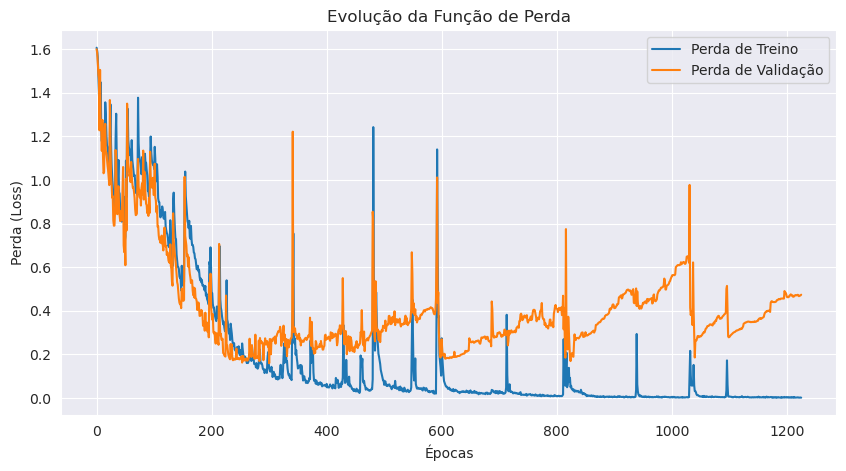

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Perda de Treino')
plt.plot(history['val_loss'], label='Perda de Validação')
plt.title('Evolução da Função de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

### Avaliação Final no Conjunto de Teste
Com o treinamento concluído, carregamos o melhor modelo (aquele com menor perda na validação) e o avaliamos no conjunto de teste, que não foi visto durante o treinamento ou seleção de modelo. Isso nos dá uma estimativa real do desempenho do modelo em dados novos.

Classification Report:
               precision    recall  f1-score   support

     business       0.96      0.96      0.96        77
entertainment       0.96      0.95      0.96        58
     politics       0.92      0.94      0.93        62
        sport       0.97      0.99      0.98        77
         tech       0.97      0.95      0.96        60

     accuracy                           0.96       334
    macro avg       0.96      0.96      0.96       334
 weighted avg       0.96      0.96      0.96       334



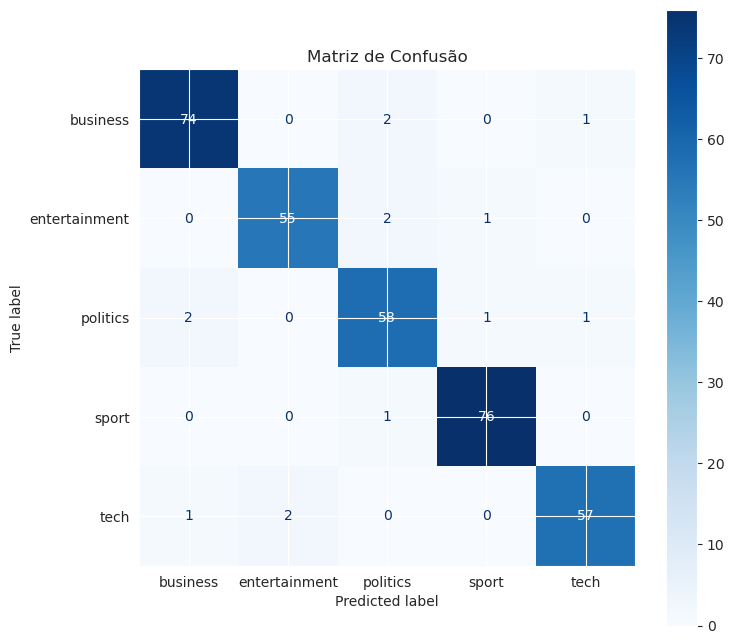

In [10]:
model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=False))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

### Testes Qualitativos
Vamos testar o modelo com algumas frases criadas por nós para ver como ele se comporta.

In [11]:
news_data = {
    "business": [
        "The central bank raised interest rates by 0.25% to combat rising inflation.",
        "Global stock markets reacted positively to the new international trade agreement.",
        "An automotive giant announced a recall of over 500,000 vehicles due to a manufacturing defect.",
        "The quarterly earnings report for the tech company surpassed all analyst expectations.",
        "A major merger between two pharmaceutical firms is set to create a new market leader.",
        "Unemployment figures dropped for the third consecutive month, signaling a strong economy.",
        "A successful IPO saw the value of the new startup's shares double on the first day of trading.",
        "Oil prices surged after key producing nations agreed to cut supply.",
        "The housing market is showing signs of cooling down after a year of rapid price growth.",
        "The CEO announced plans to step down following a period of disappointing sales figures."
    ],
    "entertainment": [
        "The latest superhero movie smashed box office records with a $200 million opening weekend.",
        "A famous pop star dropped a surprise album that is now topping charts worldwide.",
        "The final season of the hit TV series received mixed reviews from fans and critics.",
        "An independent film was the unexpected winner of the top prize at the Cannes Film Festival.",
        "A legendary rock band has announced a final world tour for next summer.",
        "The historical drama \"Echoes of the Crown\" won the award for Best Picture.",
        "Casting for the much-anticipated fantasy novel adaptation was finally revealed.",
        "A new Broadway musical opened to rave reviews and sold-out shows.",
        "The streaming service canceled a popular sci-fi series, sparking outrage from its fanbase.",
        "The lead actor confirmed he will not be returning for the franchise's next sequel."
    ],
    "politics": [
        "The president signed a new environmental protection bill into law after months of debate.",
        "World leaders are gathering in Geneva for a summit on global security and cooperation.",
        "The government narrowly survived a no-confidence vote in parliament.",
        "Election results show the ruling party has secured a majority for another four-year term.",
        "A new foreign policy initiative aims to strengthen ties with neighboring countries.",
        "Protesters gathered outside the capitol building to demonstrate against the proposed tax increase.",
        "The prime minister announced a major cabinet reshuffle, appointing a new Minister of Finance.",
        "Diplomatic talks have begun to resolve the ongoing border dispute between the two nations.",
        "The Supreme Court will rule on a landmark case concerning digital privacy rights.",
        "A new legislation was passed to provide subsidies for renewable energy projects."
    ],
    "sport": [
        "The home team won the championship with a last-second goal in a dramatic final.",
        "A star quarterback has signed a record-breaking contract extension worth $150 million.",
        "The veteran tennis player announced her retirement after a long and successful career.",
        "A stunning upset in the World Cup saw the underdog nation defeat the reigning champions.",
        "The team's manager was fired following a series of disappointing losses.",
        "A key player will miss the rest of the season due to a serious knee injury.",
        "The Brazilian driver secured pole position for Sunday's Grand Prix.",
        "The swimmer broke a world record and took home his third gold medal of the Olympic Games.",
        "A major trade between two rival basketball teams has shaken up the league.",
        "The golf tournament was decided by a single stroke in a tense final round."
    ],
    "tech": [
        "The company launched its new flagship smartphone with an advanced AI-powered camera.",
        "A major cybersecurity breach exposed the personal data of millions of users.",
        "Scientists developed a new battery technology that could double the life of electronic devices.",
        "A new software update for the operating system includes several new privacy features.",
        "A private aerospace company successfully launched a rocket carrying commercial satellites.",
        "The social media platform announced it would be cracking down on misinformation.",
        "A breakthrough in quantum computing could solve problems that are impossible for current machines.",
        "The new virtual reality headset offers a completely immersive experience for gamers.",
        "A leading AI research lab released a new open-source model that can generate realistic images.",
        "Governments are discussing new regulations for artificial intelligence to ensure ethical development."
    ]
}

In [12]:
def predict_text(text, model, glove_model, encoder, device, max_length):
    model.eval()
    with torch.no_grad():
        embeddings = text_to_embeddings(text, glove_model, max_length)
        # Adiciona uma dimensão de batch (batch_size=1)
        embeddings = embeddings.unsqueeze(0).to(device)

        output = model(embeddings)
        _, predicted_idx = torch.max(output, 1)
        predicted_label = encoder.inverse_transform([predicted_idx.item()])
        return predicted_label[0]

total_correct = 0
total_texts = 0

for true_category, headlines in news_data.items():
    print(f"\n--- Testando Categoria: {true_category.upper()} ---")
    for headline in headlines:
        predicted_category = predict_text(headline, model, glove_model, encoder, device, MAX_SEQ_LENGTH)

        total_texts += 1

        if predicted_category.lower() == true_category.lower():
            result = "CORRETO"
            total_correct += 1
        else:
            result = "INCORRETO"

        print(f"Notícia: \"{headline}\"")
        print(f"  -> Predição: {predicted_category} | Categoria Real: {true_category} | Resultado: {result}\n")


accuracy = (total_correct / total_texts) * 100
print("="*50)
print("Resumo do Teste:")
print(f"Total de Notícias Testadas: {total_texts}")
print(f"Predições Corretas: {total_correct}")
print(f"Acurácia nos dados de teste: {accuracy:.2f}%")
print("="*50)


--- Testando Categoria: BUSINESS ---
Notícia: "The central bank raised interest rates by 0.25% to combat rising inflation."
  -> Predição: business | Categoria Real: business | Resultado: CORRETO

Notícia: "Global stock markets reacted positively to the new international trade agreement."
  -> Predição: business | Categoria Real: business | Resultado: CORRETO

Notícia: "An automotive giant announced a recall of over 500,000 vehicles due to a manufacturing defect."
  -> Predição: business | Categoria Real: business | Resultado: CORRETO

Notícia: "The quarterly earnings report for the tech company surpassed all analyst expectations."
  -> Predição: business | Categoria Real: business | Resultado: CORRETO

Notícia: "A major merger between two pharmaceutical firms is set to create a new market leader."
  -> Predição: business | Categoria Real: business | Resultado: CORRETO

Notícia: "Unemployment figures dropped for the third consecutive month, signaling a strong economy."
  -> Predição: 

### Ponto Extra

In [85]:
from transformers import BertTokenizer, BertModel

MODEL_NAME = 'bert-base-uncased'

df = load_dataset(dataset_name="hgultekin/bbcnewsarchive", seed=SEED)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert_model = BertModel.from_pretrained(MODEL_NAME).to(device)
bert_model.eval()
print("Modelo BERT carregado com sucesso.")

Modelo BERT carregado com sucesso.


### Geração dos Embeddings com BERT

In [86]:
EMBEDDINGS_FILE = 'models/bert_embeddings.pt'

all_embeddings = []

batch_size = 16

with torch.no_grad():
    for i in tqdm(range(0, len(df['content']), batch_size)):
        batch_texts = df['content'][i:i+batch_size].tolist()

        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
        ).to(device)

        outputs = bert_model(**inputs)

        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
        all_embeddings.append(cls_embeddings)

bert_embeddings = torch.cat(all_embeddings, dim=0)
print(f"Salvando {len(bert_embeddings)} embeddings em '{EMBEDDINGS_FILE}'...")
torch.save(bert_embeddings, EMBEDDINGS_FILE)

print(f"Shape do tensor de embeddings: {bert_embeddings.shape}")

100%|██████████| 140/140 [00:14<00:00,  9.36it/s]

Salvando 2225 embeddings em 'models/bert_embeddings.pt'...
Shape do tensor de embeddings: torch.Size([2225, 768])


### Preparando Dados e o Modelo MLP

In [87]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [88]:
y_tensor = torch.tensor(encoder.transform(df['category'].to_numpy()), dtype=torch.long)

x_train_bert, x_temp_bert, y_train_bert, y_temp_bert = train_test_split(
    bert_embeddings, y_tensor, test_size=0.3, random_state=SEED, stratify=y_tensor
)
x_val_bert, x_test_bert, y_val_bert, y_test_bert = train_test_split(
    x_temp_bert, y_temp_bert, test_size=0.5, random_state=SEED, stratify=y_temp_bert
)

train_ds_bert = TensorDataset(x_train_bert, y_train_bert)
val_ds_bert = TensorDataset(x_val_bert, y_val_bert)
test_ds_bert = TensorDataset(x_test_bert, y_test_bert)

train_loader_bert = DataLoader(train_ds_bert, batch_size=BATCH_SIZE, shuffle=True)
val_loader_bert = DataLoader(val_ds_bert, batch_size=BATCH_SIZE)
test_loader_bert = DataLoader(test_ds_bert, batch_size=BATCH_SIZE)

### Treinamento e Avaliação do MLP

In [89]:
BERT_EMBEDDING_DIM = bert_embeddings.shape[1] # 768
MLP_HIDDEN_DIM = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
PATIENCE = 20

mlp_model = MLP(
    input_dim=BERT_EMBEDDING_DIM,
    hidden_dim=MLP_HIDDEN_DIM,
    output_dim=NUM_CLASSES,
    dropout_prob=DROPOUT_PROB
).to(device)

criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)

history_mlp = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
BEST_MLP_MODEL_PATH = 'models/best_mlp_model_accuracy.pth'

best_val_accuracy = 0.0
patience_counter = 0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    mlp_model.train()
    total_train_loss = 0
    for inputs, labels in train_loader_bert:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mlp.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion_mlp(outputs, labels)
        loss.backward()
        optimizer_mlp.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader_bert)
    history_mlp['train_loss'].append(avg_train_loss)

    mlp_model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader_bert:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            loss = criterion_mlp(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader_bert)
    val_accuracy = correct_predictions / total_samples
    history_mlp['val_loss'].append(avg_val_loss)
    history_mlp['val_accuracy'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Best Val Accuracy: {best_val_accuracy:.4f} | Patience Counter: {patience_counter} | Best Epoch: {best_epoch}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        best_epoch = epoch + 1
        torch.save(mlp_model.state_dict(), BEST_MLP_MODEL_PATH)
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping ativado na época {epoch+1}! A acurácia não melhora há {PATIENCE} épocas.')
        break

print("\nTreinamento concluído.")
mlp_model.load_state_dict(torch.load(BEST_MLP_MODEL_PATH, weights_only=False))

print(f"Melhor modelo (acurácia: {best_val_accuracy:.4f}) carregado.")

Epoch 1/500 | Train Loss: 0.9859 | Val Loss: 0.4986 | Val Accuracy: 0.9222 | Best Val Accuracy: 0.0000 | Patience Counter: 0 | Best Epoch: 0
Epoch 2/500 | Train Loss: 0.3929 | Val Loss: 0.2684 | Val Accuracy: 0.9371 | Best Val Accuracy: 0.9222 | Patience Counter: 0 | Best Epoch: 1
Epoch 3/500 | Train Loss: 0.2447 | Val Loss: 0.1859 | Val Accuracy: 0.9491 | Best Val Accuracy: 0.9371 | Patience Counter: 0 | Best Epoch: 2
Epoch 4/500 | Train Loss: 0.1876 | Val Loss: 0.1396 | Val Accuracy: 0.9611 | Best Val Accuracy: 0.9491 | Patience Counter: 0 | Best Epoch: 3
Epoch 5/500 | Train Loss: 0.1478 | Val Loss: 0.1202 | Val Accuracy: 0.9701 | Best Val Accuracy: 0.9611 | Patience Counter: 0 | Best Epoch: 4
Epoch 6/500 | Train Loss: 0.1215 | Val Loss: 0.1045 | Val Accuracy: 0.9671 | Best Val Accuracy: 0.9701 | Patience Counter: 0 | Best Epoch: 5
Epoch 7/500 | Train Loss: 0.1003 | Val Loss: 0.0920 | Val Accuracy: 0.9671 | Best Val Accuracy: 0.9701 | Patience Counter: 1 | Best Epoch: 5
Epoch 8/500 |

### Análise da Curva de Aprendizado
O gráfico abaixo mostra a evolução da função de perda (loss) nos conjuntos de treino e validação ao longo das épocas. Idealmente, ambas as curvas devem diminuir e convergir. Se a perda de treino continua caindo enquanto a de validação sobe, é um sinal de overfitting.

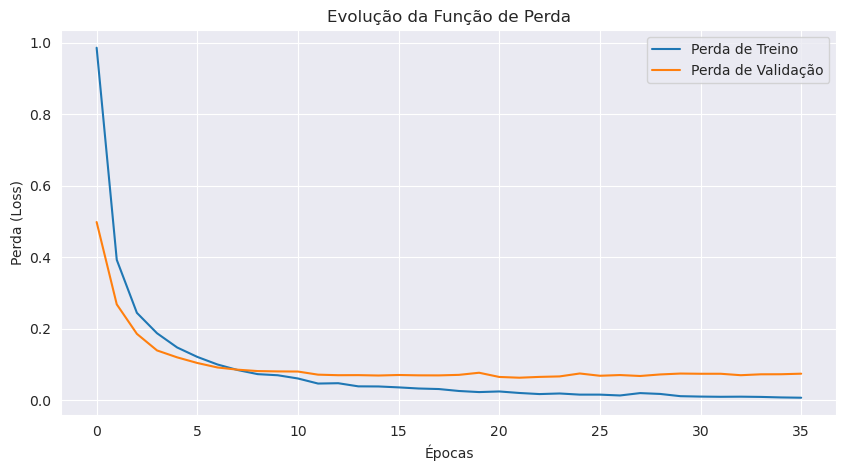

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(history_mlp['train_loss'], label='Perda de Treino')
plt.plot(history_mlp['val_loss'], label='Perda de Validação')
plt.title('Evolução da Função de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

### Avaliação Final no Conjunto de Teste
Com o treinamento concluído, carregamos o melhor modelo (aquele com menor perda na validação) e o avaliamos no conjunto de teste, que não foi visto durante o treinamento ou seleção de modelo. Isso nos dá uma estimativa real do desempenho do modelo em dados novos.

Classification Report (BERT + MLP):
               precision    recall  f1-score   support

     business       0.97      0.96      0.97        77
entertainment       0.98      0.98      0.98        58
     politics       0.97      0.97      0.97        62
        sport       1.00      1.00      1.00        77
         tech       0.95      0.97      0.96        60

     accuracy                           0.98       334
    macro avg       0.98      0.98      0.98       334
 weighted avg       0.98      0.98      0.98       334



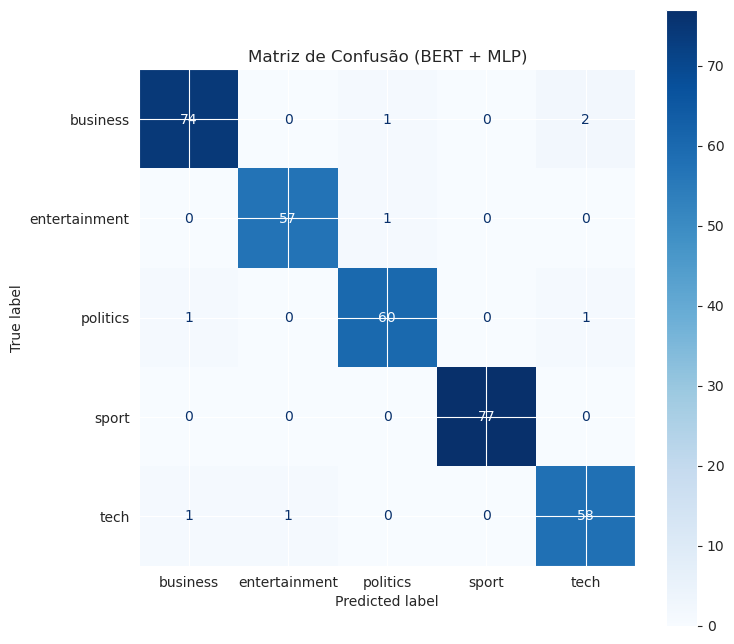

In [91]:
mlp_model.load_state_dict(torch.load(BEST_MLP_MODEL_PATH, weights_only=False))
mlp_model.eval()
all_preds_mlp = []
all_labels_mlp = []

with torch.no_grad():
    for inputs, labels in test_loader_bert:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mlp_model(inputs)

        _, predicted = torch.max(outputs, 1)
        all_preds_mlp.extend(predicted.cpu().numpy())
        all_labels_mlp.extend(labels.cpu().numpy())

print("Classification Report (BERT + MLP):")
print(classification_report(all_labels_mlp, all_preds_mlp, target_names=encoder.classes_))

cm_mlp = confusion_matrix(all_labels_mlp, all_preds_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp_mlp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão (BERT + MLP)')
plt.show()

In [92]:
def predict_text_bert(text, mlp_model, bert_tokenizer, bert_model, encoder, device):
    mlp_model.eval()
    bert_model.eval()

    with torch.no_grad():
        inputs = bert_tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=256
        ).to(device)

        outputs = bert_model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]

        prediction_logits = mlp_model(embedding)

        _, predicted_idx = torch.max(prediction_logits, 1)
        predicted_label = encoder.inverse_transform([predicted_idx.item()])

        return predicted_label[0]

In [93]:
total_correct = 0
total_texts = 0

for true_category, headlines in news_data.items():
    print(f"\n--- Testando Categoria: {true_category.upper()} ---")
    for headline in headlines:
        predicted_category = predict_text_bert(headline, mlp_model, tokenizer, bert_model, encoder, device)

        total_texts += 1

        if predicted_category.lower() == true_category.lower():
            result = "CORRETO"
            total_correct += 1
        else:
            result = "INCORRETO"

        print(f"Notícia: \"{headline}\"")
        print(f"  -> Predição: {predicted_category.upper()} | Resultado: {result}\n")


accuracy = (total_correct / total_texts) * 100
print("="*50)
print("Resumo do Teste Qualitativo:")
print(f"Total de Notícias Testadas: {total_texts}")
print(f"Predições Corretas: {total_correct}")
print(f"Acurácia nos dados de teste: {accuracy:.2f}%")
print("="*50)


--- Testando Categoria: BUSINESS ---
Notícia: "The central bank raised interest rates by 0.25% to combat rising inflation."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "Global stock markets reacted positively to the new international trade agreement."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "An automotive giant announced a recall of over 500,000 vehicles due to a manufacturing defect."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "The quarterly earnings report for the tech company surpassed all analyst expectations."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "A major merger between two pharmaceutical firms is set to create a new market leader."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "Unemployment figures dropped for the third consecutive month, signaling a strong economy."
  -> Predição: BUSINESS | Resultado: CORRETO

Notícia: "A successful IPO saw the value of the new startup's shares double on the first day of trading.